In [1]:


!pip install roboschool==1.0.48 gym==0.15.4

!pip install box2d-py # 2d rigid body physics engine

!pip install pybullet

     |████████████████████████████████| 44.9 MB 1.4 MB/s 
     |████████████████████████████████| 1.6 MB 41.1 MB/s 
     |████████████████████████████████| 1.0 MB 45.0 MB/s 
  Created wheel for gym: filename=gym-0.15.4-py3-none-any.whl size=1648485 sha256=d4cc020ca0930e39d64060671ef8ca6fb2a0a7752b443aef77234bef4aa4d73a
  Stored in directory: /root/.cache/pip/wheels/27/97/51/3adbfe67f40bce89b8eba2d3b8f42ec1c9f9c1e6305a73510d
Successfully built gym
  Attempting uninstall: pyglet
    Found existing installation: pyglet 1.5.0
    Uninstalling pyglet-1.5.0:
      Successfully uninstalled pyglet-1.5.0
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
ERROR: pip's dependency resolver does not currently take into account all the pack

**Import libraries and set device to gpu**


In [ ]:
import os
import glob
import time
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
import numpy as np
import gym
import roboschool





In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

In [ ]:

class PPOMemory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.probs = []
        self.rewards = []
        self.dones = []
    def store_memory(self, state, action, action_logprob):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(action_logprob)
    
    

    def clear_memory(self):
        self.actions=[]
        self.states=[]
        self.probs=[]
        self.rewards=[]
        self.dones=[]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, action_std_init):
        super(ActorCritic, self).__init__()

        self.action_dim = action_dim
        self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        self.actor = nn.Sequential(
                        nn.Linear(state_dim,64),
                        nn.Tanh(),
                        nn.Linear(64 ,64),
                        nn.Tanh(),
                        nn.Linear(64, action_dim),
                        nn.Tanh()   #if discrete action space = sftmax
                    )


        
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )
    def act(self, state):
        action_mean = self.actor(state)
        cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
        dist = MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        return action.detach(), action_logprob.detach()
    def criticize(self, state, action):
        action_mean = self.actor(state)
        action_var = self.action_var.expand_as(action_mean)
        cov_mat = torch.diag_embed(action_var).to(device)
        dist = MultivariateNormal(action_mean, cov_mat)
        action_probs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_probs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip,  action_std_init=0.1):


        self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = PPOMemory()

        self.policy = ActorCritic(state_dim, action_dim,  action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim,  action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    def select_action(self, state):

        with torch.no_grad():
            state = torch.FloatTensor(state).to(device)
            action, action_logprob = self.policy_old.act(state)

        self.buffer.store_memory(state,action,action_logprob)


        return action.detach().cpu().numpy().flatten()




    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.dones)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        # rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_probs = torch.squeeze(torch.stack(self.buffer.probs, dim=0)).detach().to(device)

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            probs, state_values, dist_entropy = self.policy.criticize(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(probs - old_probs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear_memory()
    
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))


# **Training**

**environnement & algorithm Hyperparemeters** 

In [13]:
env_name = "RoboschoolAtlasForwardWalk-v1"
max_ep_len = 1000                   # max timesteps in one episode
max_training_timesteps = int(1000000)   # break training loop if timeteps > max_training_timesteps
print_freq = max_ep_len * 10        # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2           # log avg reward in the interval (in num timesteps)
save_model_freq = 10000             # save model frequency (in num timesteps)
action_std = 0.1                    # starting std for action distribution (Multivariate Normal)
update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 80               # update policy for K epochs in one PPO update The idea in PPO is that you want to reuse the batch many times to update the current policy.This means you repeat your training' k. epoch amount of times for the same batch of trajectories.
eps_clip = 0.2          # clip parameter for PPO 2 
gamma = 0.99            # discount factor
lr_actor = 0.001       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network
random_seed = 0         # set random seed if required (0 = no random seed)

## Note : print/log frequencies should be > than max_ep_len


In [14]:
# Training 
env = gym.make(env_name)
# state space dimension
state_dim = env.observation_space.shape[0]
# action space dimension
action_dim = env.action_space.shape[0]




###################### logging ######################

#### log files for multiple runs are NOT overwritten

log_dir = "Logs"
if not os.path.exists(log_dir):
      os.makedirs(log_dir)




#### get number of log files in log directory
run_num = 0
current_num_files = next(os.walk(log_dir))[2]
run_num = len(current_num_files)#kaddeh mawjoud men wahed deja



#### create new log file for each run 
log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

print("logging at : " + log_f_name)



################### checkpointing ###################

run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder

directory = "Checkpoints"
if not os.path.exists(directory):
      os.makedirs(directory)

directory = directory + '/' + env_name + '/'
if not os.path.exists(directory):
      os.makedirs(directory)


checkpoint_path = directory + "checkpoint_{}_{}.pth".format(random_seed, run_num_pretrained)
print("save checkpoint path : " + checkpoint_path)
print("state space dimension : ", state_dim)
print("action space dimension : ", action_dim)

################# training procedure ################

# initialize a PPO agent
Agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip,  action_std)

# logging file
log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')


# printing and logging variables
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
episode_n = 0


# training loop
while time_step <= max_training_timesteps:
    
    state = env.reset()
    current_ep_reward = 0

    for t in range(1, max_ep_len):
        
        # select action with policy
        action = Agent.select_action(state)
        state, reward, done, _ = env.step(action)
        
        # saving reward and is_terminals
        Agent.buffer.rewards.append(reward)
        Agent.buffer.dones.append(done)
        
        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            Agent.update()



        # log in logging file
        if time_step % log_freq == 0:

            # log average reward till last episode
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)

            log_f.write('{},{},{}\n'.format(episode_n, time_step, log_avg_reward))
            log_f.flush()

            log_running_reward = 0
            log_running_episodes = 0

        # printing average reward
        if time_step % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)

            print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(episode_n, time_step, print_avg_reward))

            print_running_reward = 0
            print_running_episodes = 0
            
        # save model weights
        if time_step % save_model_freq == 0:
            Agent.save(checkpoint_path)
            print("model saved")
            
        # break; if the episode is over
        if done:
            break

    print_running_reward += current_ep_reward
    print_running_episodes += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    episode_n += 1


log_f.close()
env.close()



logging at : Logs/PPO_RoboschoolAtlasForwardWalk-v1_log_1.csv
save checkpoint path : Checkpoints/RoboschoolAtlasForwardWalk-v1/checkpoint_0_0.pth
state space dimension :  70
action space dimension :  30
Episode : 353 		 Timestep : 10000 		 Average Reward : 43.49
model saved
Episode : 700 		 Timestep : 20000 		 Average Reward : 43.44
model saved
Episode : 1055 		 Timestep : 30000 		 Average Reward : 44.98
model saved
Episode : 1407 		 Timestep : 40000 		 Average Reward : 48.57
model saved
Episode : 1758 		 Timestep : 50000 		 Average Reward : 48.63
model saved
Episode : 2110 		 Timestep : 60000 		 Average Reward : 51.14
model saved
Episode : 2462 		 Timestep : 70000 		 Average Reward : 52.28
model saved
Episode : 2814 		 Timestep : 80000 		 Average Reward : 53.01
model saved
Episode : 3168 		 Timestep : 90000 		 Average Reward : 53.18
model saved
Episode : 3512 		 Timestep : 100000 		 Average Reward : 56.52
model saved
Episode : 3860 		 Timestep : 110000 		 Average Reward : 57.09
model 

**plotting learning curve**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data= pd.read_csv('/content/Logs/PPO_RoboschoolAtlasForwardWalk-v1_log_1.csv')

In [2]:
data

,episode,timestep,reward
0,70,2000,42.1334
1,141,4000,41.9877
2,212,6000,45.6661
3,283,8000,41.7731
4,353,10000,45.9115
...,...,...,...
495,30095,992000,112.9763
496,30145,994000,108.3683
497,30194,996000,111.4996
498,30242,998000,114.3506


In [3]:
episodes=list(data["episode"])
rewards=list(data["reward"])

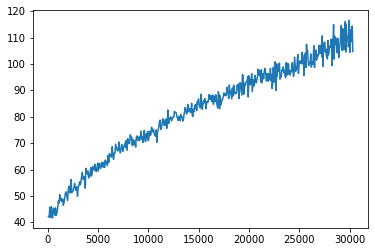

In [4]:
plt.plot(episodes, rewards)
